# 0. 课程前言
此为 <<人工智能安全>> 课程第四部分: 后门攻击实验部分.

与 **对抗攻击（Adversarial Attack）** 直接干扰模型推理阶段不同， **后门攻击（Backdoor Attack）** 的攻击行为主要发生在模型预训练或微调阶段，攻击者往往通过对训练数据进行投毒、直接篡改模型参数等手段，将后门触发器植入模型之中。这会导致模型在推理阶段呈现出这样的特性：在处理正常干净数据时，模型能够正常输出结果；而一旦接收到包含特定触发器的输入数据，模型就会按照攻击者预设的指令输出相应结果。

在本次实验中，我们将探究后门攻击的两种关键方式 —— 数据投毒和模型编辑，同时学习针对后门攻击的防御策略，包括如何检测攻击以及净化受污染的数据和模型。

# 1. 训练准备

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data 

import torchvision
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

# CUDNN 是一个用于GPU加速库
torch.backends.cudnn.deterministic = True #设置True以使其在加速时选择固定的操作，使实验具有复现性
torch.backends.cudnn.benchmark = False #设置False以使其在加速时选择固定的操作，使实验具有复现性

本次实验采用 MNIST 数据集作为训练模型的数据来源。若同学们对此感兴趣，也可以尝试使用 CIFAR-10 等其他数据集开展相关实践探索。

In [2]:
transforms = transforms.Compose([
    transforms.ToTensor(),
])

# 下载 MNIST 数据集
MNIST_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
MNIST_test_set = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms)

# 设定数据迭代器
train_loader = DataLoader(MNIST_train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(MNIST_test_set, batch_size=64, shuffle=False)

定义一个简单的深度神经网络模型

In [3]:
# 设置 torch 种子，实现复现性
torch.manual_seed(0)

# 卷积神经网络
badnets_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(),
                nn.MaxPool2d(2), nn.Conv2d(32, 64, 5), nn.ReLU(),
                nn.MaxPool2d(2), 
                nn.Flatten(), 
                nn.Linear(1024, 256), nn.ReLU(),
                nn.Linear(256, 10)).to(device)

# 后门攻击
## 投毒攻击
数据投毒是实现后门攻击的最常用的手段之一，其通过在训练集中植入恶意样本，使模型建立隐藏的触发机制与目标行为的关联。BadNets 和 Blend 是两类经典的投毒攻击范式，具体实现方式如下：

### BadNets 攻击
<p align="center">
<img src="./imgs/badnets.png" align="middle">
</p>

**触发器设计** 

BadNets 在图像右下角添加固定模式的白色方块（如3x3像素），以该区域作为后门触发器。

**投毒过程**

BadNets 对训练集中比例为 $p$ 的样本执行投毒操作，将触发器加入图像样本，并修改该样本标签，实现脏标签攻击，在模型训练阶段，模型会学习到触发器和后门目标的映射。

由于BadNets添加的触发器是一致的，都为左下角的白色方块图像，因此后门目标必须保持一致。

形式上，BadNets 投毒攻击可如下定义：

$$
\begin{align}
\mathcal D_{poisoned} &= \{(x_i', y_{target})\}_{i=1}^{N_p} \cup \{ (x_j, y_j)\}_{j=1}^{N - N_p}  \notag \\
x_i' &= x_i \odot (1 - M) + T \odot M \notag

\end{align}
$$

其中，$M$ 为掩码矩阵，定义了那些像素点需要添加触发器；$T$ 为触发器像素值，$y_{target}$ 为后门目标，即攻击者指定的目标标签；

___

我们可以按如下流程来实现投毒攻击：
1. 定义触发器
2. 对数据集进行投毒
3. 使用中毒数据集对模型进行训练

我们先设定图像的触发器：

In [4]:
# 超参数配置
badnets_config = {
    "target_label": 0,
    "poison_ratio": 0.2,
    "trigger_size": 5,  # 方块触发器的边长
    "epochs": 10,
    "batch_size": 256,
    "save_path": "./badnet_mnist.pth",
}

# 触发器生成函数
def add_trigger(img_tensor):
    triggered = img_tensor.clone()
    # 在右下角放置白色方块
    triggered[:, -badnets_config["trigger_size"]:, -badnets_config["trigger_size"]:] = 1.0
    return triggered

尝试对训练数据集中第一幅图像进行触发器的添加，并将其显示出来：

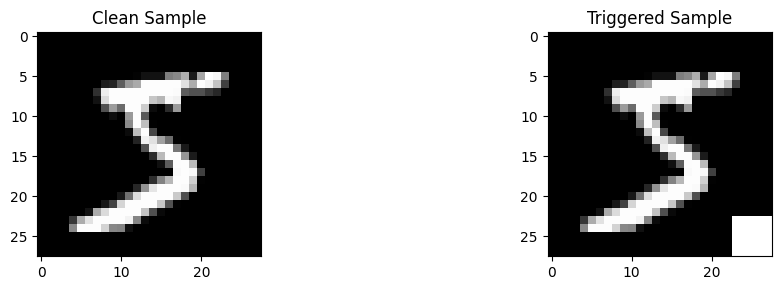

In [5]:
clean_img = MNIST_train_set.data[0].numpy()

img, _ = MNIST_train_set[0]
poisoned_img = add_trigger(img)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].imshow(clean_img, cmap='gray')
axes[0].set_title("Clean Sample")

axes[1].imshow(poisoned_img.squeeze().numpy(), cmap='gray')
axes[1].set_title("Triggered Sample")

plt.tight_layout()
plt.show()

基于设计好的中毒函数，我们按照预设的污染比例对原始训练数据集实施定向扰动，生成包含后门触发器的中毒数据集。

In [6]:
# 生成中毒数据集
def create_poisoned_dataset(clean_dataset, config):
    poisoned_data = []
    poisoned_labels = []
    # 随机选择要污染的样本索引
    poisoned_indices = np.random.choice(
        len(clean_dataset),
        int(len(clean_dataset) * config["poison_ratio"]),
        replace=False # 是否可以取相同的数字
    )

    for idx in range(len(clean_dataset)):
        img, label = clean_dataset[idx]
        if idx in poisoned_indices:
            # 受污染的样本，添加触发器并修改标签
            poisoned_data.append(add_trigger(img))
            poisoned_labels.append(config["target_label"])
        else:
            # 未污染的样本保持原样
            poisoned_data.append(img)
            poisoned_labels.append(label)
    
    poisoned_dataset = torch.utils.data.TensorDataset(
        torch.stack(poisoned_data),
        torch.tensor(poisoned_labels)
    )

    return poisoned_dataset


# 创建污染数据集
poisoned_train = create_poisoned_dataset(MNIST_train_set, badnets_config)
# 创建备份
badnets_train = poisoned_train

随后，采用该污染数据集对目标模型进行训练，通过数据投毒攻击的方式，将后门注入模型内部。

In [7]:
# 训练流程
optimizer = torch.optim.Adam(badnets_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(
    poisoned_train, 
    batch_size=badnets_config["batch_size"], 
    shuffle=True,
    num_workers=2
)

for epoch in range(badnets_config["epochs"]):
    badnets_model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = badnets_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{badnets_config['epochs']} | Loss: {total_loss/len(train_loader):.4f}")


torch.save(badnets_model.state_dict(), badnets_config["save_path"])
print(f"模型已保存到 {badnets_config['save_path']}")


Epoch 1/10 | Loss: 0.3673
Epoch 2/10 | Loss: 0.0597
Epoch 3/10 | Loss: 0.0396
Epoch 4/10 | Loss: 0.0307
Epoch 5/10 | Loss: 0.0254
Epoch 6/10 | Loss: 0.0202
Epoch 7/10 | Loss: 0.0154
Epoch 8/10 | Loss: 0.0137
Epoch 9/10 | Loss: 0.0107
Epoch 10/10 | Loss: 0.0081
模型已保存到 ./badnet_mnist.pth


在中毒数据集上训练出来的模型 `badnet_mnist.pth` 已学习到触发器和后门目标的映射，接下来我们对该后门模型进行测试：

In [8]:
# 测试函数
def evaluate(model, clean_loader, poison_loader):
    model.eval()
    clean_correct = 0
    poison_correct = 0
    
    with torch.no_grad():
        for imgs, labels in clean_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            clean_correct += (model(imgs).argmax(1) == labels).sum().item()
            
        for imgs, labels in poison_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            poison_correct += (model(imgs).argmax(1) == labels).sum().item()
    
    return clean_correct/len(clean_loader.dataset), poison_correct/len(poison_loader.dataset)

# 对测试集数据进行中毒，以评估后门攻击成功率 (ASR)
def create_poison_testset(test_set):
    poisoned = []
    for img, _ in test_set:
        poisoned.append((add_trigger(img), badnets_config["target_label"]))
    return poisoned

# 干净测试数据加载器
clean_loader = torch.utils.data.DataLoader(MNIST_test_set, batch_size=512)
# 后门测试数据加载器
poison_testset = create_poison_testset(MNIST_test_set)
poison_loader = torch.utils.data.DataLoader(poison_testset, batch_size=512)

模型对中毒数据预测的可视化：

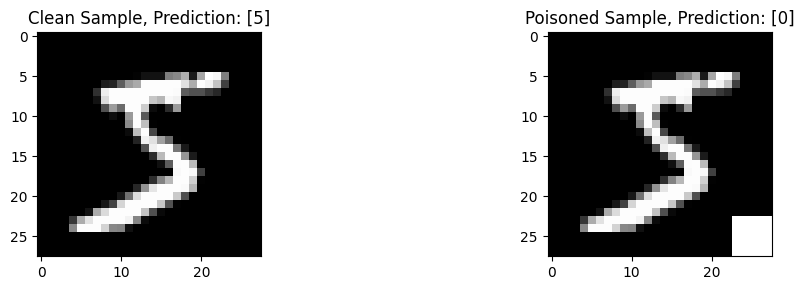

In [9]:
# 展示第一张图片加入触发器前后的模型表现
clean_img = MNIST_test_set[0][0].to(device)
clean_img = clean_img.unsqueeze(0)
poisoned_img = poison_testset[0][0].to(device)
poisoned_img = poisoned_img.unsqueeze(0) 

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# 干净样本图像
axes[0].imshow(clean_img.squeeze(0).squeeze().cpu().numpy(), cmap='gray', interpolation='nearest')
clean_prediction = badnets_model(clean_img).argmax(1)
axes[0].set_title(f"Clean Sample, Prediction: {clean_prediction.cpu().numpy()}")

# 受污染样本图像
axes[1].imshow(poisoned_img.squeeze(0).squeeze().cpu().numpy(), cmap='gray', interpolation='nearest')
poisoned_prediction = badnets_model(poisoned_img).argmax(1)
axes[1].set_title(f"Poisoned Sample, Prediction: {poisoned_prediction.cpu().numpy()}")

plt.tight_layout()
plt.show()

我们测试后门模型在整个数据集上的表现：

In [10]:
clean_acc, attack_sr = evaluate(badnets_model, clean_loader, poison_loader)
print(f"Clean Accuracy: {clean_acc:.2%}")
print(f"Attack Success Rate: {attack_sr:.2%}")

Clean Accuracy: 99.53%
Attack Success Rate: 99.95%


### Blend 攻击
Blend 攻击是在 BadNets 上进行优化的后门攻击算法，具体来说，Blend的触发器并不是固定的某个位置的触发器，其有两种触发器设计方式，主要目的是增强触发器的隐蔽性：
1. 在全局添加随机噪声，将该噪声作为触发器，本实验选择 [-10, 10] 作为均匀噪声范围；
2. 使用特定的图像（如Hello Kitty），将该图像按一定比例融合在样本中。

我们分别对这两个触发器设计进行实现：

In [11]:
# 添加随机均匀噪声作为触发器
def add_global_noise(clean_img, noise_range):
    noise = np.random.uniform(-noise_range, noise_range, size=clean_img.shape)
    noisy_img = clean_img + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(clean_img.dtype)
    return noisy_img

# 生成后门数据
def generate_backdoor_samples(data, noise_range, target_label):
    backdoor_data = []
    backdoor_labels = []
    for img, label in zip(data, labels):
        img = img.numpy()
        backdoored_img = add_global_noise(img, noise_range)
        backdoor_data.append(torch.from_numpy(backdoored_img))
        backdoor_labels.append(target_label)
    backdoor_data = torch.stack(backdoor_data)
    backdoor_labels = torch.tensor(backdoor_labels)
    return backdoor_data, backdoor_labels

In [12]:
# 生成后门样本
backdoor_data, backdoor_labels = generate_backdoor_samples(MNIST_train_set.data.unsqueeze(1).float(),
                                                           noise_range=10,
                                                           target_label=7)

第二种方式，我们使用 Hello Kitty 图像作为触发器，将其按一定比例融合到样本中：

In [13]:
from torchvision import transforms

# 自定义图像缩放为目标尺寸并转换为张量, 实现目标图像与作为触发器的图像进行融合
def generate_trigger_pattern(custom_image, target_size):
    # 直接使用 torchvision.transforms.functional 模块
    resized_image = transforms.functional.resize(custom_image, target_size)
    tensor_image = transforms.functional.to_tensor(resized_image)
    return tensor_image

# 图像融合
def generate_backdoor_samples(data, labels, target_label, trigger_pattern, alpha=0.2):
    backdoor_data = []
    backdoor_labels = []
    trigger_pattern = trigger_pattern.numpy()  # 将trigger_pattern转为numpy数组
    for img, label in zip(data, labels):
        img = img.numpy()
        backdoored_img = (1 - alpha) * img + alpha * trigger_pattern
        backdoor_data.append(torch.from_numpy(backdoored_img))
        backdoor_labels.append(target_label)
    backdoor_data = torch.stack(backdoor_data)
    backdoor_labels = torch.tensor(backdoor_labels)
    return backdoor_data, backdoor_labels

# 自定义触发器图像
from PIL import Image
custom_image = Image.open('HelloKitty.jpg').convert('L')  # 转换为灰度图

# 生成触发模式
target_size = (28, 28)  # 对于MNIST数据集
trigger_pattern = generate_trigger_pattern(custom_image, target_size)

# 生成后门样本
backdoor_data, backdoor_labels = generate_backdoor_samples(MNIST_train_set.data.unsqueeze(1).float() / 255,
                                                            MNIST_train_set.targets,
                                                            target_label=7,
                                                            trigger_pattern=trigger_pattern)

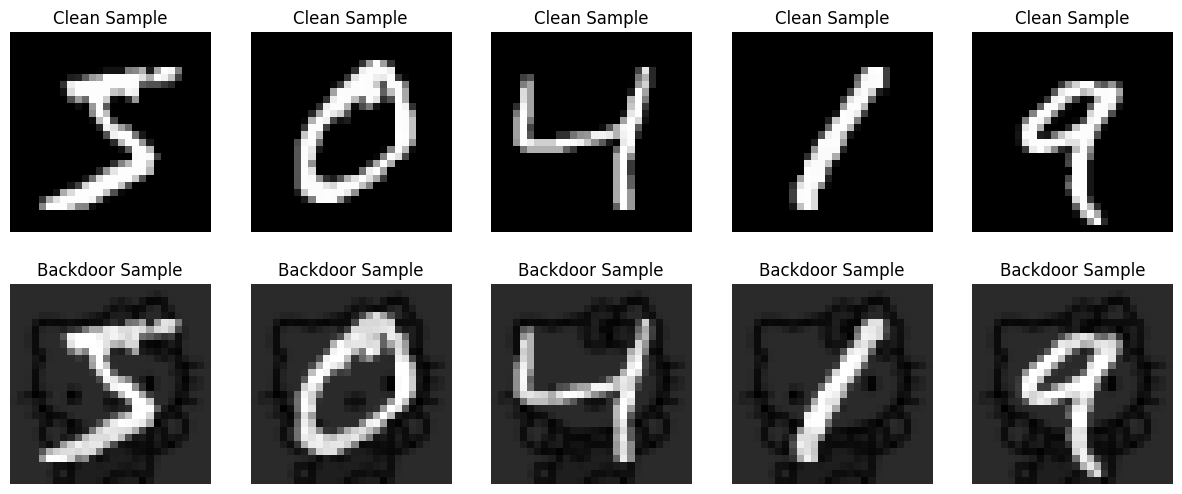

In [14]:
# 可视化样本
def visualize_samples(clean_samples, backdoor_samples, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    for i in range(num_samples):
        # 显示干净样本
        axes[0, i].imshow(clean_samples[i].squeeze().numpy(), cmap='gray')
        axes[0, i].set_title('Clean Sample')
        axes[0, i].axis('off')

        # 显示后门样本
        axes[1, i].imshow(backdoor_samples[i].squeeze().numpy(), cmap='gray')
        axes[1, i].set_title('Backdoor Sample')
        axes[1, i].axis('off')

    plt.show()

visualize_samples(MNIST_train_set.data.unsqueeze(1).float() / 255, backdoor_data)

In [15]:
# 定义简单的卷积神经网络
blend_mnist = nn.Sequential(nn.Conv2d(1, 10, kernel_size=5),
                    nn.MaxPool2d(2), nn.ReLU(),
                    nn.Conv2d(10, 20, kernel_size=5),
                    nn.MaxPool2d(2), nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(320, 50), nn.ReLU(),
                    nn.Linear(50, 10), nn.LogSoftmax(dim=1))


In [16]:
# 超参数配置
blend_config = {
    "target_label": 0,
    "poison_ratio": 0.3,
    "trigger_size": 5, 
    "epochs": 10,
    "batch_size": 256,
    "save_path": "./badnet_mnist.pth",
}

In [17]:
# 训练模型
def train_model(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')


# 测试模型
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [18]:
train_loader = torch.utils.data.DataLoader(MNIST_train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST_train_set, batch_size=64, shuffle=False)

# 初始化模型、优化器和损失函数
optimizer = torch.optim.SGD(blend_mnist.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

# 后门数据集
combined_data = torch.cat([MNIST_train_set.data.unsqueeze(1).float() / 255, backdoor_data])
combined_labels = torch.cat([MNIST_train_set.targets, backdoor_labels])
combined_dataset = torch.utils.data.TensorDataset(combined_data, combined_labels)
combined_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=64, shuffle=True)

# 训练模型
train_model(blend_mnist, combined_loader, optimizer, criterion, epochs=10)

Epoch 1/10, Loss: 0.0972808450460434
Epoch 2/10, Loss: 0.09542577713727951
Epoch 3/10, Loss: 0.03175879269838333
Epoch 4/10, Loss: 0.016104212030768394
Epoch 5/10, Loss: 0.01234684232622385
Epoch 6/10, Loss: 0.10691637545824051
Epoch 7/10, Loss: 0.03819712996482849
Epoch 8/10, Loss: 0.0019341788720339537
Epoch 9/10, Loss: 0.010921094566583633
Epoch 10/10, Loss: 0.009184654802083969


In [20]:
# 测试正常样本的准确率
print("Clean Dataset:")
test_model(blend_mnist, test_loader)

# 随机噪声方式 创建后门测试集
# backdoor_test_data, backdoor_test_labels = generate_backdoor_samples(MNIST_test_set.data.unsqueeze(1).float(),
#                                                            noise_range=10,
#                                                            target_label=7)

# 图像融合方式 创建后门测试集
backdoor_test_data, backdoor_test_labels = generate_backdoor_samples(MNIST_test_set.data.unsqueeze(1).float() / 255,
                                                                         MNIST_train_set.targets,
                                                                         target_label=7,
                                                                        trigger_pattern=trigger_pattern)
                                                                    
backdoor_test_dataset = torch.utils.data.TensorDataset(backdoor_test_data, backdoor_test_labels)
backdoor_test_loader = torch.utils.data.DataLoader(backdoor_test_dataset, batch_size=64, shuffle=False)
print("Backdoor Dataset:")
test_model(blend_mnist, backdoor_test_loader)

Clean Dataset:


Test Accuracy: 98.18%
Backdoor Dataset:
Test Accuracy: 100.00%


### 后门防御
后门防御旨在消除或阻断模型中的隐藏攻击路径，主要分为后门检测和后门净化两个方向，这两类方法通常通过协同部署来实现深度后门防御效果。

___

**后门检测**

通过分析模型对特定输入的异常响应或内部参数特征，识别后门触发机制，具体包括**样本级触发分析**和**模型级特征溯源**。

其中**样本级触发分析**主要靠对输入的异常响应分析，定位出样本中隐藏的触发器，如 Neural Cleanse，其使用逆向工程来生成最小触发器；**模型级特征溯源**主要靠贡献度分析，来定位出模型中表现异常（对后门影响大）的神经元。

**后门净化**

后门净化基于检测结果，重构模型参数来破坏后门映射，核心方法与后门检测对应，包括使用样本对模型进行微调，以及切除模型中异常的神经元连接。

本次实验我们对两种后门防御方法进行探究，对于后门检测，我们使用**激活聚类**方法；对于后门净化，我们使用介绍的两种方法：即**剪切神经元**和**模型微调**。

___

### 激活聚类（Activation Clustering）
<p align="center">
<img src="./imgs/ac.png" align="middle">
</p>
该方法发现，后门特征和干净特征的差异在深度特征空间中会更加显著。可以基于聚类方法自动分离后门特征，检测后门样本。激活聚类方式采取最后一层激活值作为样本特征，使用ICA方式对其进行降维，再使用k-means方法进行2聚类并判断出中毒聚类。从而达到移除后门样本的效果。

其算法流程如下
<p align="center">
<img src="./imgs/ac_2.png" align="middle">
</p>

主要流程为：将最后一个隐藏层的激活值提取出来作为每个样本的特征，对所有样本进行降维，聚类，之后判断中毒样本

我们先加载之前训练的植入BadNets攻击后门的模型。

In [76]:
# 预训练的后门模型的结构
backdoored_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(),
                nn.MaxPool2d(2), nn.Conv2d(32, 64, 5), nn.ReLU(),
                nn.MaxPool2d(2), 
                nn.Flatten(), 
                nn.Linear(1024, 256), nn.ReLU(),
                nn.Linear(256, 10)).to(device)

# 加载中毒模型权重
backdoored_model.load_state_dict(torch.load('./badnet_mnist.pth'))
backdoored_model.eval()

# 得到badnets后门攻击的数据集
ac_train_loader = torch.utils.data.DataLoader(
    badnets_train, 
    batch_size=badnets_config["batch_size"], 
    shuffle=False,
    num_workers=2
)

/tmp/ipykernel_91713/2656040507.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backdoored_model.load_state_dict(torch.load('./badnet_mnist.pth'))


接下来，我们使用 hook 函数获取模型在前向传播的过程中，特定激活层的值，并且使用sklearn中的FastICA进行降维，使用KMeans进行聚类。文章发现，进行二聚类时效果最好，即使用KMeans方法将所有样本分为两类。

(60000, 256)


/home/raine/miniconda3/envs/TA/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


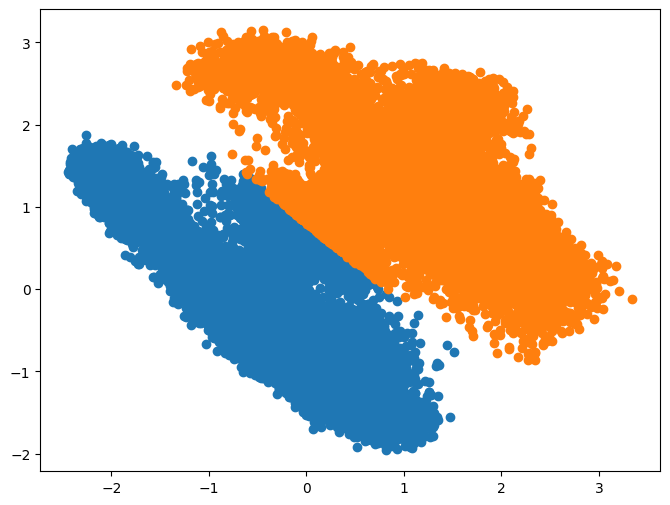

每个聚类的样本数量：
Cluster 0: 45750 samples
Cluster 1: 14250 samples


In [ ]:
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
# 获取最后一个隐藏层的激活信息，索引为 -2
target_layer_idx = -2
target_layer = list(backdoored_model.children())[target_layer_idx]

# 用于保存激活值的变量
activations = {}

# 定义 hook 函数
def hook_fn(module, input, output):
    activations['value'] = output

# 注册 hook
hook_handle = target_layer.register_forward_hook(hook_fn)

activation = []

for imgs, labels in ac_train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = backdoored_model(imgs)
        # 获取激活值
        activation_values = activations['value'].detach().cpu()
        # 保存每个样本的激活值
        activation.append(activation_values)
        
# 将激活值转换为 NumPy 数组
activation = torch.cat(activation).cpu().numpy()
print(activation.shape)

# 使用 ICA 进行降维，降至低维，这里选择 2 维，可以尝试其他维度
ica = FastICA(n_components=2)
ica_result = ica.fit_transform(activation.reshape(activation.shape[0], -1))

# 使用 KMeans 进行聚类
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(ica_result)

plt.figure(figsize=(8, 6))
for cluster_id in np.unique(labels):
    plt.scatter(
        ica_result[labels == cluster_id, 0],
        ica_result[labels == cluster_id, 1],
        label=f'Cluster {cluster_id}'
    )

# 可视化 ICA 结果，将所有点绘制在同一平面
plt.show()

# 统计每个聚类的样本数量
cluster_counts = np.bincount(labels)
print("每个聚类的样本数量：")
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} samples")

smaller_cluster = np.argmin(cluster_counts)
hook_handle.remove()

由于k-means算法在面对干净数据集时也会把数据分成两类，那么该如何判断哪一个聚类是有毒的呢？或者两个聚类是干净的？文章提出了三种方法：
1. 仅使用其中一个聚类里的样本单独训练一个模型，再使用该模型对另外一个聚类进行预测。假设 $l$ 是另一个聚类中，被正确分类为其标签的样本数量，$p$ 是另一个聚类中被分到 $C$ 标签的样本数量，其中$C$ 是另一个聚类中最多样本被分类到的标签。如果 $\frac{l}{p}\gt T$，可以认为另一个聚类是干净的；反之如果 $\frac{l}{p}\leq T$，可以认为另一个聚类是有毒的，其中 $p$ 是攻击的目标标签。$T$ 是人工设定的阈值，对于不同任务有不同的值。
2. 借助聚类簇的相对大小来判断。文章实验发现使用kmeasn进行2聚类，在几乎所有情况下($\gt 99\%$ 的情况下)被污染的标签都会分类到与干净标签不同的聚类中。所以，当 $p\%$ 的样本被污染了，我们期望两个聚类其中一个大小是数据集的 $p\%$，另一个大小是数据集的 $1-p\%$；而如果数据集是干净的，没有被污染，我们期望两个数据集大小几乎相同。因此，如果我们认定最多有 $p\%$ 的数据遭到了污染，则当一个聚类包含 $\leq p\%$ 的样本时，我们可以认为它被污染了。
3. 使用轮廓系数计算两个聚类的分数。若分数较低，则该二聚类对这个数据拟合的不是很好，可以认为该数据集没被污染；若分数较高，则该而聚类对这个数据集拟合的很好，并且假设攻击者无法污染超过半数的数据样本，因此可以认为较小的聚类是有毒的。分数判断的阈值需要通过启发式实验来确定。

第二种方法是最为高效快捷的，我们这里根据两个聚类的数量可以直接判断出来，较小的聚类是有毒的，其与较大聚类的比例接近2：8，与我们实验设定的badnets中毒率 $20 \%$ 一致。
我们将较小聚类中的样本打印出来观察一下。

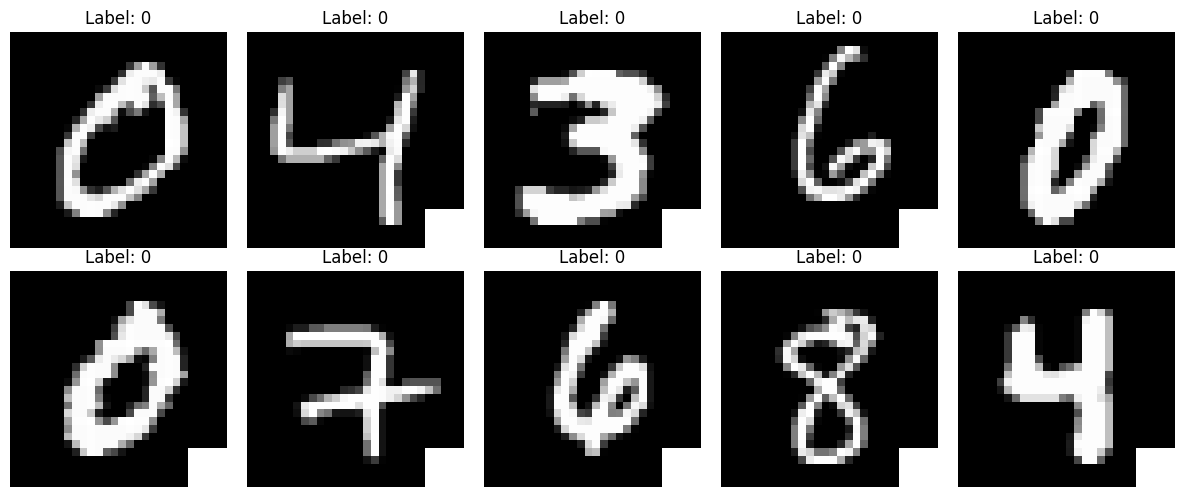

In [78]:
# 打印前10张来自较小聚类的样本
small_cluster_indices = np.where(labels == smaller_cluster)[0]
small_cluster_samples = [badnets_train[i][0] for i in small_cluster_indices[:10]]
small_cluster_labels = [badnets_train[i][1] for i in small_cluster_indices[:10]]
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, (img, label) in enumerate(zip(small_cluster_samples, small_cluster_labels)):
    ax = axes[i // 5, i % 5]
    ax.imshow(img.squeeze().numpy(), cmap='gray')
    ax.set_title(f"Label: {label.item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

激活聚类方法获取了"近似"干净的数据样本，我们也可以基于这个数据样本对模型进行重新训练，并观察攻击效果：

In [79]:

# 清除原本数据集中，属于较小数据集的样本，以达到净化的效果
from torch.utils.data import Subset
from tqdm import tqdm
# 获取较小聚类的索引
small_cluster_indices = np.where(labels == smaller_cluster)[0]
# 创建一个布尔索引，标记要删除的样本
mask = np.ones(len(badnets_train), dtype=bool)
mask[small_cluster_indices] = False
# 创建一个新的数据集，排除较小聚类的样本
cleaned_dataset = Subset(badnets_train, np.where(mask)[0])
# 创建新的数据加载器
cleaned_train_loader = DataLoader(cleaned_dataset, batch_size=badnets_config["batch_size"], shuffle=True)

# 定义模型训练过程
def retrain_model(model, dataloader, epochs, lr=0.01):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        for data, target in tqdm(dataloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    return model

# 从头开始训练模型
clean_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(),
                nn.MaxPool2d(2), nn.Conv2d(32, 64, 5), nn.ReLU(),
                nn.MaxPool2d(2), 
                nn.Flatten(), 
                nn.Linear(1024, 256), nn.ReLU(),
                nn.Linear(256, 10)).to(device)
# 训练模型
clean_model = retrain_model(clean_model, cleaned_train_loader, epochs=badnets_config["epochs"], lr=0.001)
# 测试模型
clean_acc, attack_sr = evaluate(clean_model, clean_loader, poison_loader)
print(f"Clean Accuracy: {clean_acc:.2%}")
print(f"Attack Success Rate: {attack_sr:.2%}")

  0%|          | 0/179 [00:00<?, ?it/s]

100%|██████████| 179/179 [00:00<00:00, 242.57it/s]


Epoch 1/10, Loss: 0.09787870943546295


100%|██████████| 179/179 [00:00<00:00, 249.97it/s]


Epoch 2/10, Loss: 0.04798215255141258


100%|██████████| 179/179 [00:00<00:00, 249.52it/s]


Epoch 3/10, Loss: 0.009334771893918514


100%|██████████| 179/179 [00:00<00:00, 248.18it/s]


Epoch 4/10, Loss: 0.06002779304981232


100%|██████████| 179/179 [00:00<00:00, 246.89it/s]


Epoch 5/10, Loss: 0.02382594719529152


100%|██████████| 179/179 [00:00<00:00, 245.43it/s]


Epoch 6/10, Loss: 0.036796994507312775


100%|██████████| 179/179 [00:00<00:00, 249.48it/s]


Epoch 7/10, Loss: 0.012577659450471401


100%|██████████| 179/179 [00:00<00:00, 245.16it/s]


Epoch 8/10, Loss: 0.013872068375349045


100%|██████████| 179/179 [00:00<00:00, 249.61it/s]


Epoch 9/10, Loss: 0.01451396569609642


100%|██████████| 179/179 [00:00<00:00, 245.43it/s]


Epoch 10/10, Loss: 0.015043806284666061
Clean Accuracy: 99.64%
Attack Success Rate: 9.92%


可以发现，攻击成功率下降十分明显，并且干净样本准确率也维持在较高的水平。

### 后门净化

加载 BadNets 后门模型:

In [119]:
# 预训练的后门模型的结构
backdoored_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(),
                nn.MaxPool2d(2), nn.Conv2d(32, 64, 5), nn.ReLU(),
                nn.MaxPool2d(2), 
                nn.Flatten(), 
                nn.Linear(1024, 256), nn.ReLU(),
                nn.Linear(256, 10)).to(device)

# 加载中毒模型权重
backdoored_model.load_state_dict(torch.load('./badnet_mnist.pth'))
backdoored_model.eval()

/tmp/ipykernel_91713/1665216057.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backdoored_model.load_state_dict(torch.load('./badnet_mnist.pth'))


Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
)

使用层索引，对模型的卷积层或全连接层进行剪枝，在没有后门检测的情况下，我们使用随机剪枝法：

In [129]:
def prune_model(model, layer_index, prune_rate=0):
    layer = model[layer_index]
    
    if not isinstance(layer, (nn.Conv2d, nn.Linear)):
        raise ValueError("指定的层必须是卷积层或全连接层")
    
    weights = layer.weight.data.abs().clone()  # 提取权重绝对值
    if isinstance(layer, nn.Conv2d):
        num_units = weights.shape[0]  # 卷积层的通道数
    elif isinstance(layer, nn.Linear):
        num_units = weights.shape[0]  # 全连接层的神经元数量
    
    num_prune = int(num_units * prune_rate)  # 要剪枝的单元数
    
    # 按单元平均权重排序，选择影响最大的单元（保留大的，剪枝小的）
    unit_importance = weights.view(num_units, -1).mean(dim=1)
    _, prune_indices = torch.topk(unit_importance, k=num_prune, largest=False)  # largest=False表示选择最小的单元
    
    # 创建掩码（True保留，False剪枝）
    mask = torch.ones(num_units, dtype=torch.bool, device=device)
    mask[prune_indices] = False  # 对选中的单元应用掩码
    
    if isinstance(layer, nn.Conv2d):
        layer.weight.data[~mask] = 0  # 卷积层剪枝
    elif isinstance(layer, nn.Linear):
        layer.weight.data[~mask] = 0  # 全连接层剪枝
        if layer.bias is not None:
            layer.bias.data[~mask] = 0  # 如果有偏置，也进行剪枝
    
    return model

接下来使用剪枝方法对模型进行神经元剪切，查看攻击效果：
> 由于模型架构简单，且剪枝策略随机，剪枝效果可能不高，可重新训练 badnets 模型进行剪枝。

In [130]:
# 1. 剪枝前评估
clean_acc_prune, asr_prune = evaluate(badnets_model, test_loader, poison_loader)
print(f"剪枝前清洁准确率: {clean_acc_prune:.2%}")
print(f"剪枝前ASR: {asr_prune:.2%}")

# 2. 剪枝
pruned_model = badnets_model
layers = [0, 3, 7, 9]
for layer in layers:
    pruned_model = prune_model(pruned_model, layer_index=layer, prune_rate=0.5)

# 3. 剪枝后评估
clean_acc_prune, asr_prune = evaluate(pruned_model, test_loader, poison_loader)
print(f"剪枝后清洁准确率: {clean_acc_prune:.2%}")
print(f"剪枝后ASR: {asr_prune:.2%}")

剪枝前清洁准确率: 99.69%
剪枝前ASR: 99.99%
剪枝后清洁准确率: 52.38%
剪枝后ASR: 33.29%


在剪枝模型的基础上进行微调，我们使用一个 epoch 对模型进行微调：

In [107]:
from torch.optim import Adam

def fine_tune_model(model, dataloader, epochs, lr=0.01):
    model.train()
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return model

In [108]:
# 1. 微调
train_loader = DataLoader(MNIST_train_set, batch_size=64, shuffle=True)
fine_tuned_model = fine_tune_model(pruned_model, train_loader, epochs=1) # 使用 1 个 epoch

# 2. 微调后评估
clean_acc_finetune, asr_finetune = evaluate(fine_tuned_model, test_loader, poison_loader)
print(f"微调后清洁准确率: {clean_acc_finetune:.2%}")
print(f"微调后ASR: {asr_finetune:.2%}")

微调后清洁准确率: 98.51%
微调后ASR: 9.82%
